# TOG-universal Attacks

This jupyter notebook demonstrates the use of TOG-unversal attacks on one of the state-of-the-art object detection algorithms: You Only Look Once v3 (YOLOv3) proposed by Joseph Redmon [[link]](https://pjreddie.com/media/files/papers/YOLOv3.pdf). We will demonstrate how to train a universal adversarial perturbation that can be used to perturb any input image such that the victim object detector is deceived with a designated malicious effect (e.g., object-vanishing). Since no per-input optimization is needed, TOG-universal is efficient and suitable for launching real-time attacks.

We use a MobileNetV1 backbone in this example, but our library also supports other object detection algorithms (e.g., SSD and Faster R-CNN and neural architectures (e.g., Darknet53 and VGG16). For more supported models and details of the adversarial attacks, you may refer to the other notebooks and the papers provided in the repository [[link]](https://github.com/git-disl/TOG).

## Initialize the Victim Detector (YOLOv3 - MobileNetV1)

You can download the pretrained weights here [[link]](https://github.com/git-disl/TOG/releases/download/pm-v1.0/YOLOv3_MobileNetV1.h5). If you need to train your own model, you can refer to the repository implementing YOLOv3 in Keras [[link]](https://github.com/Adamdad/keras-YOLOv3-mobilenet). Once you have downloaded or trained the YOLOv3 detector, you need to *modify* the path in the cell below to point to the `.h5` file. 

In [1]:
weights = 'model_weights/YOLOv3_MobileNetV1.h5'  # TODO: Change this path to the victim model weights

Import libraries and initialize the victim detector

In [ ]:
from dataset_utils.preprocessing import letterbox_image_padded
from misc_utils.visualization import visualize_detections
from models.yolov3 import YOLOv3_MobileNetV1
from matplotlib import pyplot as plt
from keras import backend as K
from PIL import Image
from tqdm import tqdm
import numpy as np
import datetime
import random
import os
K.clear_session()

detector = YOLOv3_MobileNetV1(weights=weights)

## Configure the Attack Hyperparameters

This demonstration uses PASCAL VOC. To train TOG-universal, we randomly pick `n_samples` training images from the dataset. You can download VOC2007 [[link]](https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar) and VOC2012 [[link]](https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar), unzip them, and update the paths below to point to the correct location.

In [3]:
VOC07_path = '/research/datasets/VOCdevkit/VOC2007'  # TODO: Change this path to your VOC2007
VOC12_path = '/research/datasets/VOCdevkit/VOC2012'  # TODO: Change this path to your VOC2012

eps = 8 / 255.        # Hyperparameter: epsilon in L-inf norm
eps_iter = 0.0001     # Hyperparameter: attack learning rate
n_epochs = 50         # Hyperparameter: number of attack iterations
n_samples = 12800      # Hyperparameter: number of training samples

Based on the paths and hyperparameters, we can then load the training images for TOG-universal.

In [4]:
fpaths_train = []  # Load image paths
for prefix in [VOC07_path, VOC12_path]:
    with open('%s/ImageSets/Main/trainval.txt' % prefix, 'r') as f:
        fpaths_train += [os.path.join(prefix, 'JPEGImages', '%s.jpg' % fname.strip()) for fname in f.readlines()]
random.shuffle(fpaths_train)  # Shuffle the image paths for random sampling
fpaths_train = fpaths_train[:n_samples]  # Select only n_samples images

## Train TOG-universal

In this demonstration, we conduct TOG-universal attacks with an object-vanishing effect. To start training the universal adversarial perturbation, we first randomly initialize `eta` based on the maximum distortion `eps` allowed in the hyperparameter setting.

In [5]:
eta = np.random.uniform(-eps, eps, size=(*detector.model_img_size, 3))

TOG-universal iteratively optimizes the universal adversarial perturbation `eta` with `n_epochs` epochs. For more descriptions about the algorithm, you can refer to our paper [[link]](https://khchow.com/media/arXiv_TOG.pdf).

In [ ]:
for epoch in range(n_epochs):
    pbar = tqdm(fpaths_train)
    pbar.set_description('Epoch %d/%d' % (epoch + 1, n_epochs))
    
    for fpath in pbar:
        input_img = Image.open(fpath)
        x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)

        x_adv = np.clip(x_query + eta, 0.0, 1.0)                  # Step 1: Apply the current eta
        grad = detector.compute_object_vanishing_gradient(x_adv)  # Step 2: Conduct one-step SGD
        signed_grad = np.sign(grad[0])
        eta = np.clip(eta - eps_iter * signed_grad, -eps, eps)    # Step 3: Extract the new eta

    random.shuffle(fpaths_train)

After `n_epochs` epochs of training, `eta` is now the universal adversarial perturbation that can be used to distort any input image to the victim detector. Since we use object-vanishing to be the designated malicious effect, the victim detector will be incapable of recognizing the existence of objects under TOG-universal.

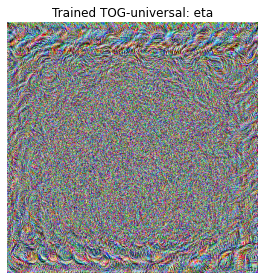

In [7]:
plt.clf()
plt.title('Trained TOG-universal: eta')
plt.imshow((eta - eta.min()) / (eta.max() - eta.min()))
plt.axis('off')
plt.tight_layout()
plt.show()

## Test TOG-universal: The Same Perturbation to Distort Different Input Images

We first use the trained universal adversarial perturbation (i.e., `eta`) to perturb an image that is not in the training set. We can observe that while the detector can recognize the dog perfectly in the benign scenario (left), it cannot detect any object given an input image perturbed by the TOG-universal (right).

<Figure size 432x288 with 0 Axes>

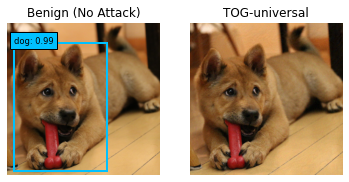

In [8]:
input_img = Image.open('./assets/example_1.jpg')
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
x_adv_vanishing = np.clip(x_query + eta, 0.0, 1.0)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-universal': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})

We then apply the same universal adversarial perturbation used above to another image, which is also not one of the images in PASCAL VOC. The person can no longer be detected by the victim under TOG-universal (right). This indicates that the same perturbation can be used to perturb different input images with consistent adversarial effects.

<Figure size 432x288 with 0 Axes>

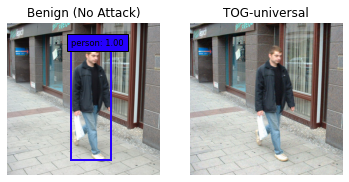

In [9]:
input_img = Image.open('./assets/example_2.png')
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
x_adv_vanishing = np.clip(x_query + eta, 0.0, 1.0)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-universal': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})